In [30]:
import TSeriesPreproccesing as TSPP
import SequencePreprocessing as SP
import ClusterProcessing as CP
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import utils as utils
import seaborn as sns
from tslearn.clustering import TimeSeriesKMeans
import os 
import pandas as pd
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [31]:
reload(TSPP)
reload(SP)
reload(CP)
pd.set_option('display.max_columns', 100)

In [32]:
tickers = ['spy','qqq']
# tickers: ['spy', 'qqq', 'nvda', 'aapl']
start = '2012-01-01'
target_cols = ['sumpctChgclose_1','sumpctChgclose_2','sumpctChgclose_3','sumpctChgclose_4','sumpctChgclose_5','sumpctChgclose_6']
n_steps = 25
interval = '1d'
cluster_features = ['pctChgclose_cumulative','pctChgvolume_cumulative']
group_params = CP.StockClusterGroupParams(start_date = start, tickers = tickers, interval = interval, target_cols = target_cols, n_steps = n_steps,cluster_features = cluster_features)
group_params.scaling_dict = {
            'price_vars': SP.ScalingMethod.SBSG,
            'trend_vars' : SP.ScalingMethod.SBS,
            'pctChg_vars' : SP.ScalingMethod.QUANT_MINMAX,
            'rolling_vars' : SP.ScalingMethod.QUANT_MINMAX_G,
            'target_vars' : SP.ScalingMethod.UNSCALED
        }

In [33]:
cluster_group = CP.StockClusterGroup(group_params)
cluster_group.create_data_set()
cluster_group.create_sequence_set()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [34]:
X_train, y_train, X_test, y_test = cluster_group.get_3d_array()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
argmin = (np.argmin(y_train[:,-1]))
print(argmin)
seq_element = cluster_group.group_params.train_seq_elements[argmin]
print(seq_element.end_date)

(4716, 25, 189)
(4716, 6)
(1144, 25, 189)
(1144, 6)
2030
2020-03-04 00:00:00


In [35]:
# df = cluster_group.data_set.training_dfs[0][target_cols]
# for column in df.columns:
#     sns.histplot(df[column], kde=True, bins=10, label=column)
# print(df.describe())

In [36]:
cluster_group.run_clustering()

(4716, 25, 1)
(1144, 25, 1)


In [37]:
reload(CP)
cluster_group.create_clusters()

Counter({11: 132, 12: 98, 8: 94, 4: 90, 14: 89, 0: 86, 1: 72, 6: 70, 13: 69, 7: 63, 2: 59, 3: 59, 10: 56, 5: 52, 15: 35, 9: 20})


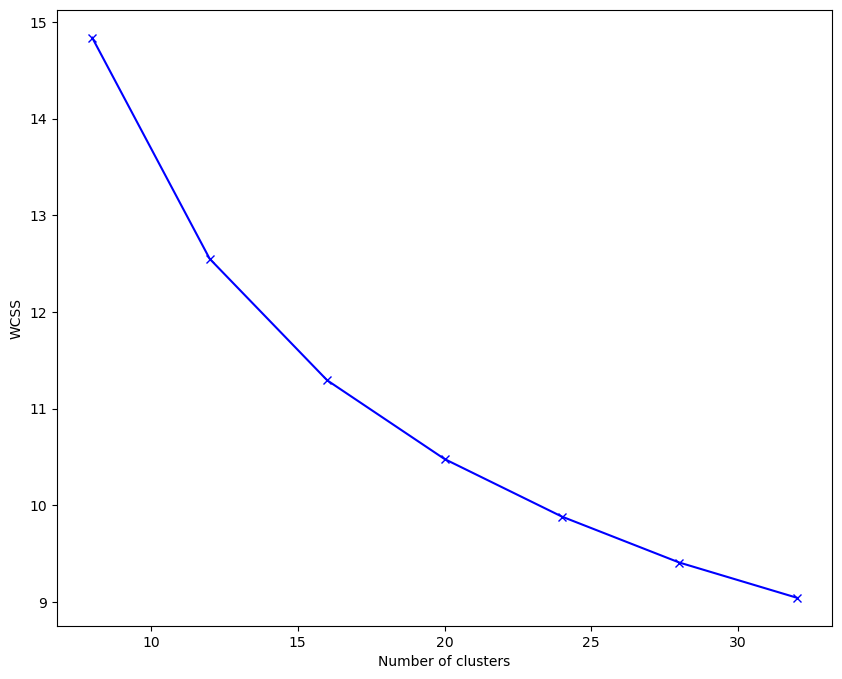

In [38]:
from collections import Counter
print(Counter(cluster_group.test_labels))

K = cluster_group.K
wcss = cluster_group.wcss

plt.figure(figsize=(10,8))
plt.plot(K, wcss, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
# plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

In [39]:
cluster_group.display_all_clusters()

In [43]:
pct_Chg_cols = next(filter(lambda feature_set: feature_set.name == 'pctChg_vars', cluster_group.group_params.X_feature_sets)).cols
cuma_cols = next((filter(lambda feature_set: "cum" in feature_set.name, cluster_group.group_params.X_feature_sets))).cols
price_cols = next((filter(lambda feature_set: "price" in feature_set.name, cluster_group.group_params.X_feature_sets))).cols

rolling_cols = [] 
rolling_features = list((filter(lambda feature_set: "rolling" in feature_set.name, cluster_group.group_params.X_feature_sets)))
for feature in rolling_features: 
    rolling_cols += feature.cols

print(rolling_cols)



['sumpctChgema10_1', 'sumpctChgema10_2', 'sumpctChgema10_3', 'sumpctChgema10_4', 'sumpctChgema10_5', 'sumpctChgema10_6', 'sumpctChgema50_1', 'sumpctChgema50_2', 'sumpctChgema50_3', 'sumpctChgema50_4', 'sumpctChgema50_5', 'sumpctChgema50_6', 'sumpctChgsma5_1', 'sumpctChgsma5_2', 'sumpctChgsma5_3', 'sumpctChgsma5_4', 'sumpctChgsma5_5', 'sumpctChgsma5_6', 'sumpctChgema30_1', 'sumpctChgema30_2', 'sumpctChgema30_3', 'sumpctChgema30_4', 'sumpctChgema30_5', 'sumpctChgema30_6', 'sumpctChgema100_1', 'sumpctChgema100_2', 'sumpctChgema100_3', 'sumpctChgema100_4', 'sumpctChgema100_5', 'sumpctChgema100_6', 'sumpctChgClLo_1', 'sumpctChgClLo_2', 'sumpctChgClLo_3', 'sumpctChgClLo_4', 'sumpctChgClLo_5', 'sumpctChgClLo_6', 'sumpctChgsma30_1', 'sumpctChgsma30_2', 'sumpctChgsma30_3', 'sumpctChgsma30_4', 'sumpctChgsma30_5', 'sumpctChgsma30_6', 'sumpctChgsma10_1', 'sumpctChgsma10_2', 'sumpctChgsma10_3', 'sumpctChgsma10_4', 'sumpctChgsma10_5', 'sumpctChgsma10_6', 'sumpctChgsma100_1', 'sumpctChgsma100_2', 'su

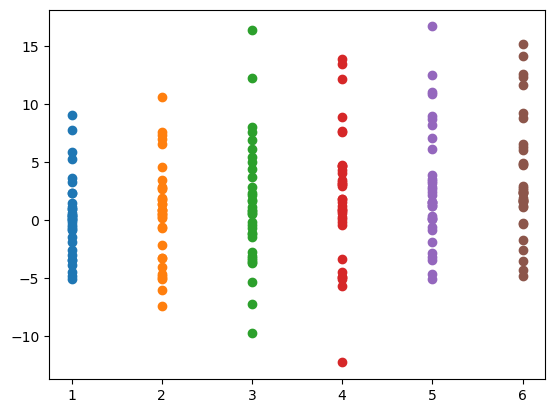

In [44]:
cluster1 = cluster_group.clusters[-1]
cluster1.visualize_target_values() 

In [45]:
train_cols = cuma_cols

cluster_group.train_all_rnns(train_cols)

2023-11-10 13:17:30.628760: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-11-10 13:17:30.628795: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: acet116-lnx-13
2023-11-10 13:17:30.628799: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: acet116-lnx-13
2023-11-10 13:17:30.628867: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.98.0
2023-11-10 13:17:30.628880: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.98.0
2023-11-10 13:17:30.628884: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.98.0
2023-11-10 13:17:30.979313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor 

Epoch 1/250


2023-11-10 13:17:32.173901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:17:32.175068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:17:32.175815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

12/13 [==========================>...] - ETA: 0s - loss: 7.2830

2023-11-10 13:17:38.955959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:17:38.956850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:17:38.957513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/13 [==============================] - 8s 158ms/step - loss: 7.2510 - val_loss: 8.0640
Epoch 2/250
13/13 [==============================] - 1s 64ms/step - loss: 5.7181 - val_loss: 8.0889
Epoch 3/250
13/13 [==============================] - 1s 64ms/step - loss: 5.0860 - val_loss: 8.0595
Epoch 4/250
13/13 [==============================] - 1s 64ms/step - loss: 4.8727 - val_loss: 7.9694
Epoch 5/250
13/13 [==============================] - 1s 64ms/step - loss: 4.8587 - val_loss: 8.0520
Epoch 6/250
13/13 [==============================] - 1s 64ms/step - loss: 4.4662 - val_loss: 7.9964
Epoch 7/250
13/13 [==============================] - 1s 64ms/step - loss: 4.2690 - val_loss: 7.9767
Epoch 8/250
13/13 [==============================] - 1s 65ms/step - loss: 3.9310 - val_loss: 7.9926
Epoch 9/250
13/13 [==============================] - 1s 65ms/step - loss: 3.8547 - val_loss: 7.6334
Epoch 10/250
13/13 [==============================] - 1s 64ms/step - loss: 4.1790 - val_loss: 8.1651
Epoch 11/2

2023-11-10 13:20:57.737241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:20:57.738495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:20:57.739174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 1s 19ms/step


2023-11-10 13:20:59.043888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:20:59.044988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:20:59.045714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/250


2023-11-10 13:20:59.899353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:20:59.900484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:20:59.901249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 9/10 [==========================>...] - ETA: 0s - loss: 4.9013

2023-11-10 13:21:06.201650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:21:06.202662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:21:06.203430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 7s 187ms/step - loss: 4.8455 - val_loss: 4.5950
Epoch 2/250
10/10 [==============================] - 1s 66ms/step - loss: 4.9841 - val_loss: 4.6546
Epoch 3/250
10/10 [==============================] - 1s 66ms/step - loss: 4.6328 - val_loss: 4.6644
Epoch 4/250
10/10 [==============================] - 1s 66ms/step - loss: 3.8962 - val_loss: 4.7311
Epoch 5/250
10/10 [==============================] - 1s 65ms/step - loss: 3.7382 - val_loss: 4.7758
Epoch 6/250
10/10 [==============================] - 1s 66ms/step - loss: 3.5661 - val_loss: 4.7396
Epoch 7/250
10/10 [==============================] - 1s 65ms/step - loss: 3.4762 - val_loss: 4.6678
Epoch 8/250
10/10 [==============================] - 1s 65ms/step - loss: 3.0352 - val_loss: 4.7021
Epoch 9/250
10/10 [==============================] - 1s 66ms/step - loss: 3.2751 - val_loss: 4.6779
Epoch 10/250
10/10 [==============================] - 1s 65ms/step - loss: 2.9773 - val_loss: 4.7530
Epoch 11/2

2023-11-10 13:23:40.419101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:23:40.420030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:23:40.420759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 1s 16ms/step


2023-11-10 13:23:41.551077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:23:41.551968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:23:41.552632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/250


2023-11-10 13:23:42.673105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:23:42.674086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:23:42.674835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/16 [===========================>..] - ETA: 0s - loss: 4.0798

2023-11-10 13:23:49.427999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:23:49.429006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:23:49.429730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

16/16 [==============================] - 8s 137ms/step - loss: 4.0147 - val_loss: 5.4822
Epoch 2/250
16/16 [==============================] - 1s 63ms/step - loss: 2.7533 - val_loss: 5.5798
Epoch 3/250
16/16 [==============================] - 1s 63ms/step - loss: 2.5225 - val_loss: 5.5254
Epoch 4/250
16/16 [==============================] - 1s 63ms/step - loss: 2.2988 - val_loss: 5.5597
Epoch 5/250
16/16 [==============================] - 1s 63ms/step - loss: 2.2139 - val_loss: 5.5780
Epoch 6/250
16/16 [==============================] - 1s 63ms/step - loss: 2.0851 - val_loss: 5.5970
Epoch 7/250
16/16 [==============================] - 1s 63ms/step - loss: 2.0125 - val_loss: 5.5744
Epoch 8/250
16/16 [==============================] - 1s 60ms/step - loss: 1.9303 - val_loss: 5.4889
Epoch 9/250
16/16 [==============================] - 1s 60ms/step - loss: 1.8906 - val_loss: 5.6344
Epoch 10/250
16/16 [==============================] - 1s 60ms/step - loss: 1.8807 - val_loss: 5.6580
Epoch 11/2

2023-11-10 13:27:48.647628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:27:48.649062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:27:48.649805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 20ms/step


2023-11-10 13:27:49.758664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:27:49.759661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:27:49.760360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/250


2023-11-10 13:27:50.621641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:27:50.622614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:27:50.623420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 9/10 [==========================>...] - ETA: 0s - loss: 4.2515

2023-11-10 13:27:57.345138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:27:57.346102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:27:57.346795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 8s 188ms/step - loss: 4.1891 - val_loss: 5.4665
Epoch 2/250
10/10 [==============================] - 1s 65ms/step - loss: 4.0675 - val_loss: 5.4762
Epoch 3/250
10/10 [==============================] - 1s 65ms/step - loss: 3.7335 - val_loss: 5.5244
Epoch 4/250
10/10 [==============================] - 1s 65ms/step - loss: 3.1857 - val_loss: 5.5202
Epoch 5/250
10/10 [==============================] - 1s 66ms/step - loss: 2.8197 - val_loss: 5.4619
Epoch 6/250
10/10 [==============================] - 1s 67ms/step - loss: 2.8501 - val_loss: 5.5800
Epoch 7/250
10/10 [==============================] - 1s 71ms/step - loss: 2.4979 - val_loss: 5.5090
Epoch 8/250
10/10 [==============================] - 1s 72ms/step - loss: 2.4592 - val_loss: 5.4965
Epoch 9/250
10/10 [==============================] - 1s 69ms/step - loss: 2.4567 - val_loss: 5.6046
Epoch 10/250
10/10 [==============================] - 1s 72ms/step - loss: 2.3537 - val_loss: 5.7333
Epoch 11/2

2023-11-10 13:30:31.689706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:30:31.690669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:30:31.691346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 21ms/step


2023-11-10 13:30:32.785489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:30:32.786455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:30:32.787138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/250


2023-11-10 13:30:33.627031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:30:33.628168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:30:33.628893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/7 [========================>.....] - ETA: 0s - loss: 6.1094

2023-11-10 13:30:39.874801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:30:39.875710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:30:39.876375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 7s 250ms/step - loss: 6.0897 - val_loss: 6.5157
Epoch 2/250
7/7 [==============================] - 0s 69ms/step - loss: 6.0016 - val_loss: 6.5390
Epoch 3/250
7/7 [==============================] - 0s 70ms/step - loss: 3.9303 - val_loss: 6.5749
Epoch 4/250
7/7 [==============================] - 0s 69ms/step - loss: 3.5031 - val_loss: 6.5524
Epoch 5/250
7/7 [==============================] - 0s 69ms/step - loss: 3.3808 - val_loss: 6.5636
Epoch 6/250
7/7 [==============================] - 0s 69ms/step - loss: 2.9394 - val_loss: 6.5498
Epoch 7/250
7/7 [==============================] - 0s 70ms/step - loss: 4.0544 - val_loss: 6.5323
Epoch 8/250
7/7 [==============================] - 0s 68ms/step - loss: 3.2045 - val_loss: 6.5693
Epoch 9/250
7/7 [==============================] - 0s 69ms/step - loss: 3.1770 - val_loss: 6.5890
Epoch 10/250
7/7 [==============================] - 0s 69ms/step - loss: 2.7154 - val_loss: 6.5860
Epoch 11/250
7/7 [============

2023-11-10 13:32:32.544042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:32:32.544801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:32:32.545634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 1s 22ms/step


2023-11-10 13:32:33.697175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:32:33.698141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:32:33.698900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/250


2023-11-10 13:32:34.920191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:32:34.921232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:32:34.922099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - ETA: 0s - loss: 4.7972

2023-11-10 13:32:41.251039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:32:41.251994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:32:41.252677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 7s 225ms/step - loss: 4.7972 - val_loss: 5.5542
Epoch 2/250
8/8 [==============================] - 1s 66ms/step - loss: 3.8160 - val_loss: 5.4768
Epoch 3/250
8/8 [==============================] - 1s 67ms/step - loss: 3.1506 - val_loss: 5.3931
Epoch 4/250
8/8 [==============================] - 1s 66ms/step - loss: 2.7772 - val_loss: 5.3581
Epoch 5/250
8/8 [==============================] - 1s 67ms/step - loss: 2.9474 - val_loss: 5.3807
Epoch 6/250
8/8 [==============================] - 1s 67ms/step - loss: 2.2775 - val_loss: 5.3809
Epoch 7/250
8/8 [==============================] - 1s 66ms/step - loss: 2.4771 - val_loss: 5.3860
Epoch 8/250
8/8 [==============================] - 1s 66ms/step - loss: 2.3476 - val_loss: 5.4308
Epoch 9/250
8/8 [==============================] - 1s 66ms/step - loss: 2.4643 - val_loss: 5.4215
Epoch 10/250
8/8 [==============================] - 1s 67ms/step - loss: 2.5306 - val_loss: 5.4052
Epoch 11/250
8/8 [============

2023-11-10 13:34:46.050463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:34:46.051369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:34:46.052069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 18ms/step


2023-11-10 13:34:47.177134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:34:47.178014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:34:47.178689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/250


2023-11-10 13:34:48.032608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:34:48.033640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:34:48.034358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

14/15 [===========================>..] - ETA: 0s - loss: 5.0082

2023-11-10 13:34:54.701158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:34:54.702376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:34:54.703185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 8s 142ms/step - loss: 4.9717 - val_loss: 3.3568
Epoch 2/250
15/15 [==============================] - 1s 64ms/step - loss: 4.2606 - val_loss: 3.3253
Epoch 3/250
15/15 [==============================] - 1s 63ms/step - loss: 3.5559 - val_loss: 3.3486
Epoch 4/250
15/15 [==============================] - 1s 64ms/step - loss: 3.3430 - val_loss: 3.3621
Epoch 5/250
15/15 [==============================] - 1s 64ms/step - loss: 3.0231 - val_loss: 3.3618
Epoch 6/250
15/15 [==============================] - 1s 64ms/step - loss: 3.2903 - val_loss: 3.2982
Epoch 7/250
15/15 [==============================] - 1s 64ms/step - loss: 3.0143 - val_loss: 3.3369
Epoch 8/250
15/15 [==============================] - 1s 62ms/step - loss: 3.0177 - val_loss: 3.2380
Epoch 9/250
15/15 [==============================] - 1s 60ms/step - loss: 2.7363 - val_loss: 3.2599
Epoch 10/250
15/15 [==============================] - 1s 60ms/step - loss: 2.5854 - val_loss: 3.3429
Epoch 11/2

2023-11-10 13:38:40.600947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:38:40.602171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:38:40.603004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 1s 17ms/step


2023-11-10 13:38:42.194544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:38:42.195494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:38:42.196227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/250


2023-11-10 13:38:43.041030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:38:43.041979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:38:43.042703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - ETA: 0s - loss: 5.8371

2023-11-10 13:38:49.316824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:38:49.317765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:38:49.318475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - 7s 203ms/step - loss: 5.8371 - val_loss: 4.2015
Epoch 2/250
9/9 [==============================] - 1s 67ms/step - loss: 5.5659 - val_loss: 4.2927
Epoch 3/250
9/9 [==============================] - 1s 66ms/step - loss: 4.1603 - val_loss: 4.3537
Epoch 4/250
9/9 [==============================] - 1s 67ms/step - loss: 3.6708 - val_loss: 4.3577
Epoch 5/250
9/9 [==============================] - 1s 66ms/step - loss: 3.7432 - val_loss: 4.3394
Epoch 6/250
9/9 [==============================] - 1s 67ms/step - loss: 3.4965 - val_loss: 4.3455
Epoch 7/250
9/9 [==============================] - 1s 67ms/step - loss: 3.2827 - val_loss: 4.3598
Epoch 8/250
9/9 [==============================] - 1s 67ms/step - loss: 3.1644 - val_loss: 4.3411
Epoch 9/250
9/9 [==============================] - 1s 67ms/step - loss: 3.1377 - val_loss: 4.4183
Epoch 10/250
9/9 [==============================] - 1s 67ms/step - loss: 3.2735 - val_loss: 4.3643
Epoch 11/250
9/9 [============

2023-11-10 13:41:10.341456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:41:10.342268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:41:10.343050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 25ms/step


2023-11-10 13:41:11.454239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:41:11.455204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:41:11.455883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/250


2023-11-10 13:41:12.299275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:41:12.300173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:41:12.300875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - ETA: 0s - loss: 9.3393

2023-11-10 13:41:18.330352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:41:18.331236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:41:18.331897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 7s 461ms/step - loss: 9.3393 - val_loss: 8.2910
Epoch 2/250
4/4 [==============================] - 0s 86ms/step - loss: 7.7016 - val_loss: 8.3693
Epoch 3/250
4/4 [==============================] - 0s 85ms/step - loss: 6.9798 - val_loss: 8.3848
Epoch 4/250
4/4 [==============================] - 0s 86ms/step - loss: 5.2060 - val_loss: 8.5066
Epoch 5/250
4/4 [==============================] - 0s 85ms/step - loss: 4.7118 - val_loss: 8.5409
Epoch 6/250
4/4 [==============================] - 0s 87ms/step - loss: 4.1157 - val_loss: 8.5990
Epoch 7/250
4/4 [==============================] - 0s 85ms/step - loss: 3.9407 - val_loss: 8.6555
Epoch 8/250
4/4 [==============================] - 0s 86ms/step - loss: 3.8217 - val_loss: 8.6307
Epoch 9/250
4/4 [==============================] - 0s 84ms/step - loss: 3.8937 - val_loss: 8.6924
Epoch 10/250
4/4 [==============================] - 0s 85ms/step - loss: 4.2097 - val_loss: 8.7612
Epoch 11/250
4/4 [============

2023-11-10 13:42:33.581761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:42:33.583023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:42:33.583958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 1s 22ms/step


2023-11-10 13:42:34.720705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:42:34.721626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:42:34.722288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/250


2023-11-10 13:42:35.562986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:42:35.564140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:42:35.565025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - ETA: 0s - loss: 8.4276

2023-11-10 13:42:42.106505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:42:42.107461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:42:42.108158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 8s 625ms/step - loss: 8.4276 - val_loss: 4.9475
Epoch 2/250
3/3 [==============================] - 0s 80ms/step - loss: 5.8390 - val_loss: 4.9169
Epoch 3/250
3/3 [==============================] - 0s 75ms/step - loss: 6.0311 - val_loss: 4.9477
Epoch 4/250
3/3 [==============================] - 0s 74ms/step - loss: 4.9507 - val_loss: 4.9210
Epoch 5/250
3/3 [==============================] - 0s 74ms/step - loss: 4.8516 - val_loss: 4.9005
Epoch 6/250
3/3 [==============================] - 0s 75ms/step - loss: 5.7635 - val_loss: 4.9218
Epoch 7/250
3/3 [==============================] - 0s 74ms/step - loss: 4.0520 - val_loss: 4.8627
Epoch 8/250
3/3 [==============================] - 0s 74ms/step - loss: 4.1865 - val_loss: 4.9000
Epoch 9/250
3/3 [==============================] - 0s 75ms/step - loss: 3.6676 - val_loss: 4.8876
Epoch 10/250
3/3 [==============================] - 0s 75ms/step - loss: 3.9971 - val_loss: 4.8477
Epoch 11/250
3/3 [============

2023-11-10 13:43:32.420136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:43:32.421119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:43:32.421849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step


2023-11-10 13:43:33.528799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:43:33.529725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:43:33.530477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/250


2023-11-10 13:43:34.383403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:43:34.384474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:43:34.385218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - ETA: 0s - loss: 4.5639

2023-11-10 13:43:40.612045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:43:40.613044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:43:40.613915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 7s 254ms/step - loss: 4.5639 - val_loss: 11.1260
Epoch 2/250
7/7 [==============================] - 0s 69ms/step - loss: 3.6150 - val_loss: 11.2509
Epoch 3/250
7/7 [==============================] - 0s 70ms/step - loss: 3.1603 - val_loss: 11.3154
Epoch 4/250
7/7 [==============================] - 0s 70ms/step - loss: 2.5962 - val_loss: 11.3206
Epoch 5/250
7/7 [==============================] - 0s 68ms/step - loss: 2.4073 - val_loss: 11.4446
Epoch 6/250
7/7 [==============================] - 0s 69ms/step - loss: 2.3039 - val_loss: 11.4185
Epoch 7/250
7/7 [==============================] - 0s 69ms/step - loss: 2.1401 - val_loss: 11.4276
Epoch 8/250
7/7 [==============================] - 0s 69ms/step - loss: 2.0343 - val_loss: 11.4340
Epoch 9/250
7/7 [==============================] - 0s 69ms/step - loss: 2.2100 - val_loss: 11.3076
Epoch 10/250
7/7 [==============================] - 0s 69ms/step - loss: 2.0128 - val_loss: 11.4055
Epoch 11/250
7/7 [==

2023-11-10 13:45:33.128447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:45:33.129376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:45:33.130134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 18ms/step


2023-11-10 13:45:34.234540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:45:34.235429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:45:34.236119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/250


2023-11-10 13:45:35.089314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:45:35.090343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:45:35.091283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/8 [=========================>....] - ETA: 0s - loss: 8.8095

2023-11-10 13:45:41.486313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:45:41.487437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:45:41.488249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 8s 234ms/step - loss: 8.8469 - val_loss: 8.9894
Epoch 2/250
8/8 [==============================] - 1s 75ms/step - loss: 9.8918 - val_loss: 8.8161
Epoch 3/250
8/8 [==============================] - 1s 74ms/step - loss: 7.7908 - val_loss: 8.7635
Epoch 4/250
8/8 [==============================] - 1s 75ms/step - loss: 6.6497 - val_loss: 8.7113
Epoch 5/250
8/8 [==============================] - 1s 74ms/step - loss: 7.0863 - val_loss: 8.6640
Epoch 6/250
8/8 [==============================] - 1s 74ms/step - loss: 6.4834 - val_loss: 8.6593
Epoch 7/250
8/8 [==============================] - 1s 74ms/step - loss: 7.0499 - val_loss: 8.5889
Epoch 8/250
8/8 [==============================] - 1s 74ms/step - loss: 6.3621 - val_loss: 8.6072
Epoch 9/250
8/8 [==============================] - 1s 74ms/step - loss: 7.4030 - val_loss: 8.6748
Epoch 10/250
8/8 [==============================] - 1s 73ms/step - loss: 6.5245 - val_loss: 8.5877
Epoch 11/250
8/8 [============

2023-11-10 13:47:57.879083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:47:57.880354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:47:57.881196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 1s 20ms/step


2023-11-10 13:47:59.058245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:47:59.059107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:47:59.059760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/250


2023-11-10 13:47:59.895998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:47:59.896949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:47:59.897670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - ETA: 0s - loss: 7.7728

2023-11-10 13:48:05.987964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:48:05.989139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:48:05.989819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 7s 173ms/step - loss: 7.7728 - val_loss: 7.0412
Epoch 2/250
11/11 [==============================] - 1s 64ms/step - loss: 7.2483 - val_loss: 7.0646
Epoch 3/250
11/11 [==============================] - 1s 63ms/step - loss: 6.1253 - val_loss: 7.0672
Epoch 4/250
11/11 [==============================] - 1s 64ms/step - loss: 5.2949 - val_loss: 7.0890
Epoch 5/250
11/11 [==============================] - 1s 64ms/step - loss: 4.8331 - val_loss: 7.0767
Epoch 6/250
11/11 [==============================] - 1s 64ms/step - loss: 4.9379 - val_loss: 7.0990
Epoch 7/250
11/11 [==============================] - 1s 64ms/step - loss: 4.3827 - val_loss: 7.1536
Epoch 8/250
11/11 [==============================] - 1s 64ms/step - loss: 4.9150 - val_loss: 7.2128
Epoch 9/250
11/11 [==============================] - 1s 64ms/step - loss: 5.0388 - val_loss: 7.2083
Epoch 10/250
11/11 [==============================] - 1s 64ms/step - loss: 4.7392 - val_loss: 7.2505
Epoch 11/2

2023-11-10 13:50:52.432925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:50:52.433881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:50:52.434576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 19ms/step


2023-11-10 13:50:53.588011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:50:53.589261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:50:53.589975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/250


2023-11-10 13:50:54.450566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:50:54.451576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:50:54.452312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

18/19 [===========================>..] - ETA: 0s - loss: 4.3273

2023-11-10 13:51:01.398021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:51:01.398925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:51:01.399661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

19/19 [==============================] - 8s 125ms/step - loss: 4.3013 - val_loss: 2.0406
Epoch 2/250
19/19 [==============================] - 1s 64ms/step - loss: 2.9982 - val_loss: 2.0575
Epoch 3/250
19/19 [==============================] - 1s 63ms/step - loss: 2.7058 - val_loss: 2.0331
Epoch 4/250
19/19 [==============================] - 1s 64ms/step - loss: 2.4832 - val_loss: 2.0014
Epoch 5/250
19/19 [==============================] - 1s 63ms/step - loss: 2.3738 - val_loss: 1.9966
Epoch 6/250
19/19 [==============================] - 1s 62ms/step - loss: 2.1945 - val_loss: 1.9619
Epoch 7/250
19/19 [==============================] - 1s 60ms/step - loss: 2.1585 - val_loss: 1.9322
Epoch 8/250
19/19 [==============================] - 1s 60ms/step - loss: 2.0848 - val_loss: 2.0199
Epoch 9/250
19/19 [==============================] - 1s 60ms/step - loss: 2.1570 - val_loss: 1.8980
Epoch 10/250
19/19 [==============================] - 1s 60ms/step - loss: 1.9546 - val_loss: 1.7714
Epoch 11/2

2023-11-10 13:55:46.024113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:55:46.025007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:55:46.025743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 1s 15ms/step


2023-11-10 13:55:47.146377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:55:47.147287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:55:47.147974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/250


2023-11-10 13:55:47.987023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:55:47.988010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:55:47.988739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

12/13 [==========================>...] - ETA: 0s - loss: 5.8162

2023-11-10 13:55:54.488256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:55:54.489310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:55:54.489996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/13 [==============================] - 8s 157ms/step - loss: 5.9420 - val_loss: 4.7778
Epoch 2/250
13/13 [==============================] - 1s 65ms/step - loss: 5.5178 - val_loss: 4.8524
Epoch 3/250
13/13 [==============================] - 1s 65ms/step - loss: 5.2326 - val_loss: 4.9032
Epoch 4/250
13/13 [==============================] - 1s 66ms/step - loss: 4.9380 - val_loss: 4.8433
Epoch 5/250
13/13 [==============================] - 1s 66ms/step - loss: 4.4223 - val_loss: 4.8369
Epoch 6/250
13/13 [==============================] - 1s 66ms/step - loss: 4.3518 - val_loss: 4.8360
Epoch 7/250
13/13 [==============================] - 1s 66ms/step - loss: 4.2904 - val_loss: 4.8448
Epoch 8/250
13/13 [==============================] - 1s 66ms/step - loss: 4.1728 - val_loss: 4.8874
Epoch 9/250
13/13 [==============================] - 1s 63ms/step - loss: 3.9579 - val_loss: 4.8669
Epoch 10/250
13/13 [==============================] - 1s 62ms/step - loss: 4.1789 - val_loss: 4.9324
Epoch 11/2

2023-11-10 13:59:15.748940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:59:15.749998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:59:15.750702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 1s 22ms/step


2023-11-10 13:59:16.881801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:59:16.882880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:59:16.883544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/250


2023-11-10 13:59:17.726086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:59:17.727247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:59:17.728025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/2 [==============>...............] - ETA: 5s - loss: 26.5667

2023-11-10 13:59:23.571466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:59:23.572488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:59:23.573237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 7s 1s/step - loss: 26.0013 - val_loss: 11.6259
Epoch 2/250
2/2 [==============================] - 0s 76ms/step - loss: 26.8232 - val_loss: 11.5357
Epoch 3/250
2/2 [==============================] - 0s 87ms/step - loss: 25.6433 - val_loss: 11.5323
Epoch 4/250
2/2 [==============================] - 0s 77ms/step - loss: 19.8069 - val_loss: 11.4644
Epoch 5/250
2/2 [==============================] - 0s 77ms/step - loss: 19.8125 - val_loss: 11.3891
Epoch 6/250
2/2 [==============================] - 0s 78ms/step - loss: 21.4502 - val_loss: 11.3450
Epoch 7/250
2/2 [==============================] - 0s 79ms/step - loss: 24.1490 - val_loss: 11.3428
Epoch 8/250
2/2 [==============================] - 0s 79ms/step - loss: 23.1025 - val_loss: 11.3851
Epoch 9/250
2/2 [==============================] - 0s 78ms/step - loss: 22.4403 - val_loss: 11.4173
Epoch 10/250
2/2 [==============================] - 0s 76ms/step - loss: 18.0032 - val_loss: 11.4683
Epoch 11/250


2023-11-10 13:59:58.052669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-10 13:59:58.053685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-10 13:59:58.054460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 2s 8ms/step


In [ ]:
# # cluster_features = ['sumPctChgclose_1','sumPctChgclose_3','sumPctChgclose_6']
# cluster_features = ['sumPctChgclose_2_cumulative']
# print(stockSequence.group_params.X_feature_dict)
# cluster_indices = [stockSequence.group_params.X_feature_dict[feature] for feature in cluster_features]
# X_cluster = utils.create_Cluster_Seq(X_train,cluster_indices)

In [ ]:
# import math
# n_clusters = math.ceil(math.sqrt(len(X_cluster))) // 3
# # A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

# km = TimeSeriesKMeans(n_clusters=n_clusters)

# labels = km.fit_predict(X_cluster)

In [ ]:
# reload(utils)
# threshold_factor = 1 # Adjust as necessary

# X_cluster_adj, X_train_adj, y_train_adj, labels_adj = utils.remove_outliers(X_cluster,X_train,y_train,labels,km,threshold_factor)
# display(X_cluster.shape)
# display(X_train.shape)
# display(y_train.shape)
# display(X_cluster_adj.shape)
# display(X_train_adj.shape)
# display(y_train_adj.shape)
# display(labels_adj.shape)

In [ ]:
# reload(utils)
# utils.visualizeData(labels_adj,X_cluster_adj)


In [ ]:
# from keras.layers import RepeatVector, TimeDistributed

# def create_model():
#     # Encoder
#     model_lstm = Sequential()
    
#     model_lstm.add(LSTM(units=250, activation='tanh', return_sequences=True, input_shape=(None, len(X_train_adj[0][0]))))
#     model_lstm.add(BatchNormalization())
#     model_lstm.add(Dropout(0.2))

#     model_lstm.add(LSTM(units=250, activation='tanh', return_sequences=True))
#     model_lstm.add(BatchNormalization())
#     model_lstm.add(Dropout(0.2))

#     model_lstm.add(LSTM(units=100, activation='tanh',return_sequences=True))
#     model_lstm.add(BatchNormalization())
#     model_lstm.add(Dropout(0.2))

#     model_lstm.add(LSTM(units=100, activation='tanh'))
#     model_lstm.add(BatchNormalization())
#     model_lstm.add(Dropout(0.2))
    
#     # Repeat the encoder output (which is the last hidden state) 
#     # for 'n' times where 'n' is the number of prediction steps
#     model_lstm.add(RepeatVector(6))  # Assuming you are predicting for 6 steps

#     # Decoder
#     model_lstm.add(LSTM(units=250, activation='tanh', return_sequences=True))
#     model_lstm.add(BatchNormalization())
#     model_lstm.add(Dropout(0.2))

#     model_lstm.add(LSTM(units=250, activation='tanh', return_sequences=True))
#     model_lstm.add(BatchNormalization())
#     model_lstm.add(Dropout(0.2))
    
#     model_lstm.add(TimeDistributed(Dense(1)))  # Predict one value for each time step

#     optimizer = Adam(learning_rate=0.001)
#     lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_lr=1e-5)

#     model_lstm.compile(optimizer=optimizer, loss="mse")
#     return model_lstm

In [ ]:
# # display(X_train[0:1,:,-1])
# X_cluster_test = utils.create_Cluster_Seq(X_test,cluster_indices)
# # display(X_cluster_test.shape)

# cluster_assignments = km.predict(X_cluster_test)


# for lab in set(labels_adj): 
#     filtered_x_train, filtered_y_train = utils.filter_clusters(labels_adj, lab, X_train_adj, y_train_adj)


#     # values, counts = np.unique(cluster_assignments, return_counts=True)

#     # # Display the results
#     # for value, count in zip(values, counts):
#     #     print(f"Value: {value}, Count: {count}")

#     X_cluster_test_adj,X_test_adj, y_test_adj, labels_test_adj = utils.remove_outliers(X_cluster_test,X_test,y_test,cluster_assignments,km,threshold_factor)


#     filtered_x_test, filtered_y_test = utils.filter_clusters(labels_test_adj, lab, X_test_adj, y_test_adj)
    
#     # display(X_cluster_test_adj.shape)
#     # display(filtered_x_test.shape)
#     # display(filtered_y_test.shape)

#     if len(filtered_x_test) == 0:
#         continue

#     # display(filtered_x_train.shape)
#     model_lstm = create_model()
#     print(filtered_x_test.shape)
#     print(filtered_y_test.shape)

#     y_train_reshaped = np.expand_dims(y_train, axis=-1)
#     y_test_reshaped = np.expand_dims(y_test, axis=-1)
    
#     model_lstm.fit(filtered_x_train, filtered_y_train, batch_size=30, epochs=300, verbose=1)

    
    
#     predicted_stock_price = model_lstm.predict(filtered_x_test)
#     predicted_stock_price = np.squeeze(predicted_stock_price, axis=-1)
#     print(predicted_stock_price.shape)



#     # predicted_stock_price = predictiveScaler.inverse_transform(predicted_stock_price)
#     # filtered_y_test = predictiveScaler.inverse_transform(filtered_y_test)

#     # Assuming predicted_stock_price has two columns
#     results = pd.DataFrame({
#         'predicted_1': predicted_stock_price[:, 0],
#         'predicted_2': predicted_stock_price[:, 1],
#         'predicted_3': predicted_stock_price[:, 2],
#         'predicted_4': predicted_stock_price[:, 3],
#         'predicted_5': predicted_stock_price[:, 4],
#         'predicted_6': predicted_stock_price[:, 5],
#         'real_1': filtered_y_test[:, 0],
#         'real_2': filtered_y_test[:, 1],
#         'real_3': filtered_y_test[:, 2],
#         'real_4': filtered_y_test[:, 3],
#         'real_5': filtered_y_test[:, 4],
#         'real_6': filtered_y_test[:, 5]
#     })

#     # Assuming a correct prediction means both predicted features have the same sign as their corresponding real values
#     results['same_1'] = ((results['predicted_1'] > 0) & (results['real_1'] > 0)) | ((results['predicted_1'] < 0) & (results['real_1'] < 0))
#     results['same_2'] = ((results['predicted_2'] > 0) & (results['real_2'] > 0)) | ((results['predicted_2'] < 0) & (results['real_2'] < 0))
#     results['same_3'] = ((results['predicted_3'] > 0) & (results['real_3'] > 0)) | ((results['predicted_3'] < 0) & (results['real_3'] < 0))
#     results['same_4'] = ((results['predicted_4'] > 0) & (results['real_4'] > 0)) | ((results['predicted_4'] < 0) & (results['real_4'] < 0))
#     results['same_5'] = ((results['predicted_5'] > 0) & (results['real_5'] > 0)) | ((results['predicted_5'] < 0) & (results['real_5'] < 0))
#     results['same_6'] = ((results['predicted_6'] > 0) & (results['real_6'] > 0)) | ((results['predicted_6'] < 0) & (results['real_6'] < 0))
#     accuracy1 = results['same_1'].sum() / len(results) * 100
#     accuracy2 = results['same_2'].sum() / len(results) * 100
#     accuracy3 = results['same_3'].sum() / len(results) * 100
#     accuracy4 = results['same_4'].sum() / len(results) * 100
#     accuracy5 = results['same_5'].sum() / len(results) * 100
#     accuracy6 = results['same_6'].sum() / len(results) * 100

#     # Construct the string
#     output_string = (
#         "Cluster Number: " + str(lab) +
#         " \nAccuracy1D " + str(accuracy1) + " PredictedRet: " + str(results['predicted_1'].mean()) + " ActRet " + str(results['real_1'].mean() ) +
#         " \nAccuracy2D " + str(accuracy2) + " PredictedRet: " + str(results['predicted_2'].mean()) + " ActRet " + str(results['real_2'].mean() ) +
#         " \nAccuracy3D " + str(accuracy3) + " PredictedRet: " + str(results['predicted_3'].mean()) + " ActRet " + str(results['real_3'].mean() ) +
#         " \nAccuracy4D " + str(accuracy4) + " PredictedRet: " + str(results['predicted_4'].mean()) + " ActRet " + str(results['real_4'].mean() ) +
#         " \nAccuracy5D " + str(accuracy5) + " PredictedRet: " + str(results['predicted_5'].mean()) + " ActRet " + str(results['real_5'].mean() ) +
#         " \nAccuracy6D " + str(accuracy6) + " PredictedRet: " + str(results['predicted_6'].mean()) + " ActRet " + str(results['real_6'].mean() ) +
#         " Test set length: " + str(len(filtered_y_test)) + "\n"
#     )

#     # Write the string to a file
#     with open('fuck.txt', 'a') as f:
#         f.write(output_string)






/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 20:29:30.757084: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-10-18 20:29:30.757117: I tensorflow/compiler/xla/str

(69, 10, 81)
(69, 6)
Epoch 1/300


2023-10-18 20:29:32.127643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:29:32.128624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:29:32.129320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/13 [==============================] - 6s 34ms/step - loss: 2.0318
Epoch 2/300
13/13 [==============================] - 0s 33ms/step - loss: 1.4424
Epoch 3/300
13/13 [==============================] - 0s 33ms/step - loss: 0.9040
Epoch 4/300
13/13 [==============================] - 0s 33ms/step - loss: 0.8543
Epoch 5/300
13/13 [==============================] - 0s 33ms/step - loss: 0.7150
Epoch 6/300
13/13 [==============================] - 0s 33ms/step - loss: 0.6277
Epoch 7/300
13/13 [==============================] - 0s 33ms/step - loss: 0.5982
Epoch 8/300
13/13 [==============================] - 0s 33ms/step - loss: 0.5874
Epoch 9/300
13/13 [==============================] - 0s 33ms/step - loss: 0.5316
Epoch 10/300
13/13 [==============================] - 0s 33ms/step - loss: 0.4584
Epoch 11/300
13/13 [==============================] - 0s 33ms/step - loss: 0.4312
Epoch 12/300
13/13 [==============================] - 0s 32ms/step - loss: 0.4289
Epoch 13/300
13/13 [=================

2023-10-18 20:31:41.208787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:31:41.209967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:31:41.210615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 1s 9ms/step
(69, 6)


/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 20:31:42.309681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a

(17, 10, 81)
(17, 6)
Epoch 1/300


2023-10-18 20:31:42.967425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:31:42.968389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:31:42.969220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 6s 33ms/step - loss: 2.1888
Epoch 2/300
5/5 [==============================] - 0s 33ms/step - loss: 2.2465
Epoch 3/300
5/5 [==============================] - 0s 32ms/step - loss: 1.9513
Epoch 4/300
5/5 [==============================] - 0s 32ms/step - loss: 1.4331
Epoch 5/300
5/5 [==============================] - 0s 33ms/step - loss: 1.4078
Epoch 6/300
5/5 [==============================] - 0s 32ms/step - loss: 1.0192
Epoch 7/300
5/5 [==============================] - 0s 32ms/step - loss: 0.9330
Epoch 8/300
5/5 [==============================] - 0s 33ms/step - loss: 0.7958
Epoch 9/300
5/5 [==============================] - 0s 33ms/step - loss: 0.6731
Epoch 10/300
5/5 [==============================] - 0s 32ms/step - loss: 0.6904
Epoch 11/300
5/5 [==============================] - 0s 32ms/step - loss: 0.6428
Epoch 12/300
5/5 [==============================] - 0s 32ms/step - loss: 0.6745
Epoch 13/300
5/5 [==============================] - 0s 32ms/s

2023-10-18 20:32:35.699708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:32:35.700757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:32:35.701441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step
(17, 6)


/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 20:32:36.751944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a

(79, 10, 81)
(79, 6)
Epoch 1/300


2023-10-18 20:32:37.412645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:32:37.413500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:32:37.414200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 6s 35ms/step - loss: 2.2025
Epoch 2/300
11/11 [==============================] - 0s 34ms/step - loss: 1.2964
Epoch 3/300
11/11 [==============================] - 0s 34ms/step - loss: 1.1606
Epoch 4/300
11/11 [==============================] - 0s 34ms/step - loss: 0.9596
Epoch 5/300
11/11 [==============================] - 0s 34ms/step - loss: 0.8130
Epoch 6/300
11/11 [==============================] - 0s 34ms/step - loss: 0.7275
Epoch 7/300
11/11 [==============================] - 0s 34ms/step - loss: 0.6018
Epoch 8/300
11/11 [==============================] - 0s 34ms/step - loss: 0.6233
Epoch 9/300
11/11 [==============================] - 0s 34ms/step - loss: 0.6051
Epoch 10/300
11/11 [==============================] - 0s 34ms/step - loss: 0.5326
Epoch 11/300
11/11 [==============================] - 0s 34ms/step - loss: 0.4875
Epoch 12/300
11/11 [==============================] - 0s 34ms/step - loss: 0.4495
Epoch 13/300
11/11 [=================

2023-10-18 20:34:29.102085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:34:29.103167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:34:29.103907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 1s 11ms/step
(79, 6)


/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 20:34:30.213581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a

(216, 10, 81)
(216, 6)
Epoch 1/300


2023-10-18 20:34:30.873010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:34:30.874005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:34:30.874916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

18/18 [==============================] - 6s 34ms/step - loss: 2.0942
Epoch 2/300
18/18 [==============================] - 1s 34ms/step - loss: 1.1699
Epoch 3/300
18/18 [==============================] - 1s 34ms/step - loss: 0.8846
Epoch 4/300
18/18 [==============================] - 1s 34ms/step - loss: 0.6747
Epoch 5/300
18/18 [==============================] - 1s 34ms/step - loss: 0.6024
Epoch 6/300
18/18 [==============================] - 1s 34ms/step - loss: 0.5587
Epoch 7/300
18/18 [==============================] - 1s 33ms/step - loss: 0.5178
Epoch 8/300
18/18 [==============================] - 1s 33ms/step - loss: 0.4355
Epoch 9/300
18/18 [==============================] - 1s 33ms/step - loss: 0.3991
Epoch 10/300
18/18 [==============================] - 1s 33ms/step - loss: 0.3676
Epoch 11/300
18/18 [==============================] - 1s 33ms/step - loss: 0.3480
Epoch 12/300
18/18 [==============================] - 1s 32ms/step - loss: 0.3355
Epoch 13/300
18/18 [=================

2023-10-18 20:37:27.219711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:37:27.220819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:37:27.221570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 12ms/step
(216, 6)


/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 20:37:28.395589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a

(12, 10, 81)
(12, 6)
Epoch 1/300


2023-10-18 20:37:29.068527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:37:29.069353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:37:29.070045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 6s 36ms/step - loss: 2.4270
Epoch 2/300
5/5 [==============================] - 0s 35ms/step - loss: 1.8753
Epoch 3/300
5/5 [==============================] - 0s 35ms/step - loss: 1.5295
Epoch 4/300
5/5 [==============================] - 0s 34ms/step - loss: 1.3101
Epoch 5/300
5/5 [==============================] - 0s 35ms/step - loss: 1.2263
Epoch 6/300
5/5 [==============================] - 0s 34ms/step - loss: 1.0746
Epoch 7/300
5/5 [==============================] - 0s 35ms/step - loss: 0.9771
Epoch 8/300
5/5 [==============================] - 0s 35ms/step - loss: 0.8524
Epoch 9/300
5/5 [==============================] - 0s 35ms/step - loss: 0.6791
Epoch 10/300
5/5 [==============================] - 0s 34ms/step - loss: 0.7174
Epoch 11/300
5/5 [==============================] - 0s 34ms/step - loss: 0.7678
Epoch 12/300
5/5 [==============================] - 0s 34ms/step - loss: 0.6228
Epoch 13/300
5/5 [==============================] - 0s 34ms/s

2023-10-18 20:38:23.512205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:38:23.513150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:38:23.513840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step
(12, 6)


/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 20:38:24.568703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a

(9, 10, 81)
(9, 6)
Epoch 1/300


2023-10-18 20:38:25.229499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:38:25.230375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:38:25.231267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 6s 33ms/step - loss: 3.0563
Epoch 2/300
5/5 [==============================] - 0s 32ms/step - loss: 2.4998
Epoch 3/300
5/5 [==============================] - 0s 32ms/step - loss: 1.6574
Epoch 4/300
5/5 [==============================] - 0s 32ms/step - loss: 1.6049
Epoch 5/300
5/5 [==============================] - 0s 31ms/step - loss: 1.3855
Epoch 6/300
5/5 [==============================] - 0s 32ms/step - loss: 1.1266
Epoch 7/300
5/5 [==============================] - 0s 32ms/step - loss: 1.2718
Epoch 8/300
5/5 [==============================] - 0s 31ms/step - loss: 1.1293
Epoch 9/300
5/5 [==============================] - 0s 32ms/step - loss: 1.0175
Epoch 10/300
5/5 [==============================] - 0s 32ms/step - loss: 0.9828
Epoch 11/300
5/5 [==============================] - 0s 31ms/step - loss: 0.9771
Epoch 12/300
5/5 [==============================] - 0s 32ms/step - loss: 0.7583
Epoch 13/300
5/5 [==============================] - 0s 31ms/s

2023-10-18 20:39:17.182633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:39:17.183715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:39:17.184413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step
(9, 6)


/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 20:39:18.269962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a

(27, 10, 81)
(27, 6)
Epoch 1/300


2023-10-18 20:39:18.938557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:39:18.939622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:39:18.940352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 6s 34ms/step - loss: 4.0059
Epoch 2/300
5/5 [==============================] - 0s 34ms/step - loss: 1.7266
Epoch 3/300
5/5 [==============================] - 0s 33ms/step - loss: 1.3604
Epoch 4/300
5/5 [==============================] - 0s 34ms/step - loss: 1.2691
Epoch 5/300
5/5 [==============================] - 0s 33ms/step - loss: 1.4394
Epoch 6/300
5/5 [==============================] - 0s 33ms/step - loss: 1.0310
Epoch 7/300
5/5 [==============================] - 0s 33ms/step - loss: 1.0248
Epoch 8/300
5/5 [==============================] - 0s 33ms/step - loss: 0.9813
Epoch 9/300
5/5 [==============================] - 0s 33ms/step - loss: 0.8505
Epoch 10/300
5/5 [==============================] - 0s 34ms/step - loss: 0.8662
Epoch 11/300
5/5 [==============================] - 0s 33ms/step - loss: 0.7545
Epoch 12/300
5/5 [==============================] - 0s 33ms/step - loss: 0.7859
Epoch 13/300
5/5 [==============================] - 0s 33ms/s

2023-10-18 20:40:12.943892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:40:12.944843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:40:12.945610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step
(27, 6)


/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 20:40:14.028295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a

(89, 10, 81)
(89, 6)
Epoch 1/300


2023-10-18 20:40:14.686172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:40:14.687227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:40:14.688047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

14/14 [==============================] - 6s 34ms/step - loss: 1.9185
Epoch 2/300
14/14 [==============================] - 0s 34ms/step - loss: 1.1398
Epoch 3/300
14/14 [==============================] - 0s 33ms/step - loss: 0.8984
Epoch 4/300
14/14 [==============================] - 0s 34ms/step - loss: 0.7225
Epoch 5/300
14/14 [==============================] - 0s 34ms/step - loss: 0.6165
Epoch 6/300
14/14 [==============================] - 0s 34ms/step - loss: 0.5584
Epoch 7/300
14/14 [==============================] - 0s 34ms/step - loss: 0.5159
Epoch 8/300
14/14 [==============================] - 0s 34ms/step - loss: 0.4417
Epoch 9/300
14/14 [==============================] - 0s 33ms/step - loss: 0.4411
Epoch 10/300
14/14 [==============================] - 0s 34ms/step - loss: 0.3918
Epoch 11/300
14/14 [==============================] - 0s 34ms/step - loss: 0.3398
Epoch 12/300
14/14 [==============================] - 0s 34ms/step - loss: 0.3371
Epoch 13/300
14/14 [=================

2023-10-18 20:42:34.501965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:42:34.502944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:42:34.503640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 1s 12ms/step
(89, 6)


/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 20:42:35.593057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a

(10, 10, 81)
(10, 6)
Epoch 1/300


2023-10-18 20:42:36.263063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:42:36.264111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:42:36.265022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 6s 36ms/step - loss: 2.2498
Epoch 2/300
3/3 [==============================] - 0s 35ms/step - loss: 2.1532
Epoch 3/300
3/3 [==============================] - 0s 36ms/step - loss: 2.4919
Epoch 4/300
3/3 [==============================] - 0s 35ms/step - loss: 1.9849
Epoch 5/300
3/3 [==============================] - 0s 36ms/step - loss: 1.3471
Epoch 6/300
3/3 [==============================] - 0s 35ms/step - loss: 1.3350
Epoch 7/300
3/3 [==============================] - 0s 35ms/step - loss: 0.9510
Epoch 8/300
3/3 [==============================] - 0s 34ms/step - loss: 1.0726
Epoch 9/300
3/3 [==============================] - 0s 35ms/step - loss: 0.8552
Epoch 10/300
3/3 [==============================] - 0s 35ms/step - loss: 0.7711
Epoch 11/300
3/3 [==============================] - 0s 34ms/step - loss: 0.8670
Epoch 12/300
3/3 [==============================] - 0s 36ms/step - loss: 0.8911
Epoch 13/300
3/3 [==============================] - 0s 35ms/s

2023-10-18 20:43:12.908479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:43:12.909377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:43:12.910029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step
(10, 6)


/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 20:43:14.357949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a

(173, 10, 81)
(173, 6)
Epoch 1/300


2023-10-18 20:43:15.035506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:43:15.036476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:43:15.037176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

19/19 [==============================] - 6s 34ms/step - loss: 1.7252
Epoch 2/300
19/19 [==============================] - 1s 34ms/step - loss: 0.9672
Epoch 3/300
19/19 [==============================] - 1s 34ms/step - loss: 0.7645
Epoch 4/300
19/19 [==============================] - 1s 34ms/step - loss: 0.6109
Epoch 5/300
19/19 [==============================] - 1s 34ms/step - loss: 0.5092
Epoch 6/300
19/19 [==============================] - 1s 34ms/step - loss: 0.4613
Epoch 7/300
19/19 [==============================] - 1s 35ms/step - loss: 0.4237
Epoch 8/300
19/19 [==============================] - 1s 36ms/step - loss: 0.4230
Epoch 9/300
19/19 [==============================] - 1s 34ms/step - loss: 0.3869
Epoch 10/300
19/19 [==============================] - 1s 34ms/step - loss: 0.3630
Epoch 11/300
19/19 [==============================] - 1s 33ms/step - loss: 0.3038
Epoch 12/300
19/19 [==============================] - 1s 34ms/step - loss: 0.3067
Epoch 13/300
19/19 [=================

2023-10-18 20:46:24.747824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:46:24.748747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:46:24.749426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 1s 13ms/step
(173, 6)


/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 20:46:25.885561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a

(12, 10, 81)
(12, 6)
Epoch 1/300


2023-10-18 20:46:26.538831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:46:26.539642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:46:26.540300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 6s 34ms/step - loss: 2.8833
Epoch 2/300
5/5 [==============================] - 0s 33ms/step - loss: 2.3675
Epoch 3/300
5/5 [==============================] - 0s 33ms/step - loss: 2.0797
Epoch 4/300
5/5 [==============================] - 0s 33ms/step - loss: 1.9573
Epoch 5/300
5/5 [==============================] - 0s 33ms/step - loss: 1.4239
Epoch 6/300
5/5 [==============================] - 0s 33ms/step - loss: 1.4620
Epoch 7/300
5/5 [==============================] - 0s 32ms/step - loss: 1.0586
Epoch 8/300
5/5 [==============================] - 0s 33ms/step - loss: 1.2385
Epoch 9/300
5/5 [==============================] - 0s 33ms/step - loss: 1.0661
Epoch 10/300
5/5 [==============================] - 0s 33ms/step - loss: 0.8130
Epoch 11/300
5/5 [==============================] - 0s 33ms/step - loss: 0.9448
Epoch 12/300
5/5 [==============================] - 0s 33ms/step - loss: 0.7669
Epoch 13/300
5/5 [==============================] - 0s 33ms/s

2023-10-18 20:47:19.762489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:47:19.763496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:47:19.764178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step
(12, 6)


/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 20:47:20.829843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a

(37, 10, 81)
(37, 6)
Epoch 1/300


2023-10-18 20:47:21.488410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:47:21.489260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:47:21.489896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 6s 35ms/step - loss: 2.7847
Epoch 2/300
6/6 [==============================] - 0s 35ms/step - loss: 1.9085
Epoch 3/300
6/6 [==============================] - 0s 34ms/step - loss: 1.5615
Epoch 4/300
6/6 [==============================] - 0s 34ms/step - loss: 1.2478
Epoch 5/300
6/6 [==============================] - 0s 34ms/step - loss: 1.1380
Epoch 6/300
6/6 [==============================] - 0s 34ms/step - loss: 1.0064
Epoch 7/300
6/6 [==============================] - 0s 34ms/step - loss: 0.9405
Epoch 8/300
6/6 [==============================] - 0s 34ms/step - loss: 0.8015
Epoch 9/300
6/6 [==============================] - 0s 33ms/step - loss: 0.7942
Epoch 10/300
6/6 [==============================] - 0s 34ms/step - loss: 0.6444
Epoch 11/300
6/6 [==============================] - 0s 34ms/step - loss: 0.5653
Epoch 12/300
6/6 [==============================] - 0s 34ms/step - loss: 0.5937
Epoch 13/300
6/6 [==============================] - 0s 34ms/s

2023-10-18 20:48:25.276571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:48:25.277694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:48:25.278442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 5ms/step
(37, 6)


/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 20:48:26.347707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a

(88, 10, 81)
(88, 6)
Epoch 1/300


2023-10-18 20:48:26.998268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:48:26.999184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:48:27.000075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

14/14 [==============================] - 6s 34ms/step - loss: 1.9070
Epoch 2/300
14/14 [==============================] - 0s 34ms/step - loss: 1.2056
Epoch 3/300
14/14 [==============================] - 0s 33ms/step - loss: 0.9630
Epoch 4/300
14/14 [==============================] - 0s 34ms/step - loss: 0.8876
Epoch 5/300
14/14 [==============================] - 0s 33ms/step - loss: 0.6162
Epoch 6/300
14/14 [==============================] - 0s 34ms/step - loss: 0.5844
Epoch 7/300
14/14 [==============================] - 0s 34ms/step - loss: 0.5760
Epoch 8/300
14/14 [==============================] - 0s 33ms/step - loss: 0.5032
Epoch 9/300
14/14 [==============================] - 0s 33ms/step - loss: 0.4505
Epoch 10/300
14/14 [==============================] - 0s 33ms/step - loss: 0.4249
Epoch 11/300
14/14 [==============================] - 0s 34ms/step - loss: 0.4020
Epoch 12/300
14/14 [==============================] - 0s 34ms/step - loss: 0.3461
Epoch 13/300
14/14 [=================

2023-10-18 20:50:44.908550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:50:44.909455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:50:44.910114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 1s 11ms/step
(88, 6)


/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 20:50:46.008651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a

(3, 10, 81)
(3, 6)
Epoch 1/300


2023-10-18 20:50:46.668214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:50:46.669088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:50:46.669753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 6s 33ms/step - loss: 3.7119
Epoch 2/300
3/3 [==============================] - 0s 31ms/step - loss: 2.5656
Epoch 3/300
3/3 [==============================] - 0s 32ms/step - loss: 2.7154
Epoch 4/300
3/3 [==============================] - 0s 31ms/step - loss: 2.6535
Epoch 5/300
3/3 [==============================] - 0s 31ms/step - loss: 1.7566
Epoch 6/300
3/3 [==============================] - 0s 31ms/step - loss: 1.7245
Epoch 7/300
3/3 [==============================] - 0s 31ms/step - loss: 1.3835
Epoch 8/300
3/3 [==============================] - 0s 31ms/step - loss: 1.4972
Epoch 9/300
3/3 [==============================] - 0s 31ms/step - loss: 1.3404
Epoch 10/300
3/3 [==============================] - 0s 32ms/step - loss: 1.1658
Epoch 11/300
3/3 [==============================] - 0s 31ms/step - loss: 1.0592
Epoch 12/300
3/3 [==============================] - 0s 31ms/step - loss: 1.1110
Epoch 13/300
3/3 [==============================] - 0s 32ms/s

2023-10-18 20:51:19.920753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:51:19.921671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:51:19.922361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step
(3, 6)


/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 20:51:21.391594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a

(89, 10, 81)
(89, 6)
Epoch 1/300


2023-10-18 20:51:22.056312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:51:22.057615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:51:22.058302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 6s 33ms/step - loss: 2.3242
Epoch 2/300
11/11 [==============================] - 0s 32ms/step - loss: 1.6180
Epoch 3/300
11/11 [==============================] - 0s 32ms/step - loss: 0.9763
Epoch 4/300
11/11 [==============================] - 0s 32ms/step - loss: 0.8087
Epoch 5/300
11/11 [==============================] - 0s 32ms/step - loss: 0.7227
Epoch 6/300
11/11 [==============================] - 0s 32ms/step - loss: 0.6190
Epoch 7/300
11/11 [==============================] - 0s 32ms/step - loss: 0.5551
Epoch 8/300
11/11 [==============================] - 0s 32ms/step - loss: 0.5137
Epoch 9/300
11/11 [==============================] - 0s 32ms/step - loss: 0.5184
Epoch 10/300
11/11 [==============================] - 0s 32ms/step - loss: 0.4446
Epoch 11/300
11/11 [==============================] - 0s 32ms/step - loss: 0.4461
Epoch 12/300
11/11 [==============================] - 0s 32ms/step - loss: 0.4006
Epoch 13/300
11/11 [=================

2023-10-18 20:53:07.919831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:53:07.920793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:53:07.921569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 1s 12ms/step
(89, 6)


/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 20:53:09.016445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a

(69, 10, 81)
(69, 6)
Epoch 1/300


2023-10-18 20:53:09.666801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:53:09.667642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:53:09.668376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 6s 33ms/step - loss: 1.8704
Epoch 2/300
11/11 [==============================] - 0s 33ms/step - loss: 1.4082
Epoch 3/300
11/11 [==============================] - 0s 33ms/step - loss: 1.0380
Epoch 4/300
11/11 [==============================] - 0s 33ms/step - loss: 0.9475
Epoch 5/300
11/11 [==============================] - 0s 33ms/step - loss: 0.7669
Epoch 6/300
11/11 [==============================] - 0s 32ms/step - loss: 0.7077
Epoch 7/300
11/11 [==============================] - 0s 33ms/step - loss: 0.6303
Epoch 8/300
11/11 [==============================] - 0s 33ms/step - loss: 0.6021
Epoch 9/300
11/11 [==============================] - 0s 33ms/step - loss: 0.5565
Epoch 10/300
11/11 [==============================] - 0s 33ms/step - loss: 0.5005
Epoch 11/300
11/11 [==============================] - 0s 33ms/step - loss: 0.4344
Epoch 12/300
11/11 [==============================] - 0s 33ms/step - loss: 0.4802
Epoch 13/300
11/11 [=================

2023-10-18 20:54:57.525814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:54:57.526716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:54:57.527378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 1s 10ms/step
(69, 6)


/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 20:54:58.613665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a

(85, 10, 81)
(85, 6)
Epoch 1/300


2023-10-18 20:54:59.276649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:54:59.277591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:54:59.278265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/13 [==============================] - 7s 33ms/step - loss: 2.6409
Epoch 2/300
13/13 [==============================] - 0s 33ms/step - loss: 1.3235
Epoch 3/300
13/13 [==============================] - 0s 33ms/step - loss: 1.0480
Epoch 4/300
13/13 [==============================] - 0s 32ms/step - loss: 0.8898
Epoch 5/300
13/13 [==============================] - 0s 32ms/step - loss: 0.7980
Epoch 6/300
13/13 [==============================] - 0s 33ms/step - loss: 0.7101
Epoch 7/300
13/13 [==============================] - 0s 33ms/step - loss: 0.6713
Epoch 8/300
13/13 [==============================] - 0s 32ms/step - loss: 0.5647
Epoch 9/300
13/13 [==============================] - 0s 32ms/step - loss: 0.5198
Epoch 10/300
13/13 [==============================] - 0s 32ms/step - loss: 0.4836
Epoch 11/300
13/13 [==============================] - 0s 32ms/step - loss: 0.4606
Epoch 12/300
13/13 [==============================] - 0s 32ms/step - loss: 0.4441
Epoch 13/300
13/13 [=================

2023-10-18 20:57:05.227672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:57:05.228977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:57:05.229702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 1s 12ms/step
(85, 6)


/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 20:57:06.338328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a

(24, 10, 81)
(24, 6)
Epoch 1/300


2023-10-18 20:57:06.985703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:57:06.986572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:57:06.987437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 6s 32ms/step - loss: 2.1649
Epoch 2/300
7/7 [==============================] - 0s 31ms/step - loss: 1.7037
Epoch 3/300
7/7 [==============================] - 0s 32ms/step - loss: 1.6142
Epoch 4/300
7/7 [==============================] - 0s 31ms/step - loss: 1.3606
Epoch 5/300
7/7 [==============================] - 0s 31ms/step - loss: 1.0875
Epoch 6/300
7/7 [==============================] - 0s 32ms/step - loss: 0.9011
Epoch 7/300
7/7 [==============================] - 0s 32ms/step - loss: 0.8584
Epoch 8/300
7/7 [==============================] - 0s 31ms/step - loss: 0.7899
Epoch 9/300
7/7 [==============================] - 0s 32ms/step - loss: 0.7203
Epoch 10/300
7/7 [==============================] - 0s 31ms/step - loss: 0.6775
Epoch 11/300
7/7 [==============================] - 0s 32ms/step - loss: 0.6404
Epoch 12/300
7/7 [==============================] - 0s 32ms/step - loss: 0.5608
Epoch 13/300
7/7 [==============================] - 0s 31ms/s

2023-10-18 20:58:16.241459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:58:16.242511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:58:16.243169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step
(24, 6)


/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 20:58:17.306329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a

(333, 10, 81)
(333, 6)
Epoch 1/300


2023-10-18 20:58:17.954838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 20:58:17.956028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 20:58:17.956744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 6s 33ms/step - loss: 1.8216
Epoch 2/300
25/25 [==============================] - 1s 33ms/step - loss: 0.8775
Epoch 3/300
25/25 [==============================] - 1s 33ms/step - loss: 0.6035
Epoch 4/300
25/25 [==============================] - 1s 33ms/step - loss: 0.4905
Epoch 5/300
25/25 [==============================] - 1s 33ms/step - loss: 0.4184
Epoch 6/300
25/25 [==============================] - 1s 33ms/step - loss: 0.3957
Epoch 7/300
25/25 [==============================] - 1s 33ms/step - loss: 0.3488
Epoch 8/300
25/25 [==============================] - 1s 31ms/step - loss: 0.3018
Epoch 9/300
25/25 [==============================] - 1s 31ms/step - loss: 0.2830
Epoch 10/300
25/25 [==============================] - 1s 31ms/step - loss: 0.2740
Epoch 11/300
25/25 [==============================] - 1s 31ms/step - loss: 0.2535
Epoch 12/300
25/25 [==============================] - 1s 31ms/step - loss: 0.2167
Epoch 13/300
25/25 [=================

2023-10-18 21:02:14.939841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 21:02:14.940739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 21:02:14.941537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 1s 11ms/step
(333, 6)


/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 21:02:16.112808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a

(213, 10, 81)
(213, 6)
Epoch 1/300


2023-10-18 21:02:17.159410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 21:02:17.160375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 21:02:17.161105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

20/20 [==============================] - 6s 35ms/step - loss: 2.0646
Epoch 2/300
20/20 [==============================] - 1s 33ms/step - loss: 1.0188
Epoch 3/300
20/20 [==============================] - 1s 33ms/step - loss: 0.7544
Epoch 4/300
20/20 [==============================] - 1s 33ms/step - loss: 0.6352
Epoch 5/300
20/20 [==============================] - 1s 34ms/step - loss: 0.5049
Epoch 6/300
20/20 [==============================] - 1s 34ms/step - loss: 0.4952
Epoch 7/300
20/20 [==============================] - 1s 34ms/step - loss: 0.4376
Epoch 8/300
20/20 [==============================] - 1s 31ms/step - loss: 0.4081
Epoch 9/300
20/20 [==============================] - 1s 34ms/step - loss: 0.3498
Epoch 10/300
20/20 [==============================] - 1s 32ms/step - loss: 0.3243
Epoch 11/300
20/20 [==============================] - 1s 34ms/step - loss: 0.2921
Epoch 12/300
20/20 [==============================] - 1s 31ms/step - loss: 0.2997
Epoch 13/300
20/20 [=================

2023-10-18 21:05:31.377036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 21:05:31.377837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 21:05:31.378617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 12ms/step
(213, 6)


/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 21:05:32.540452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a

(45, 10, 81)
(45, 6)
Epoch 1/300


2023-10-18 21:05:33.221011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 21:05:33.222004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 21:05:33.222616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 6s 33ms/step - loss: 2.8775
Epoch 2/300
8/8 [==============================] - 0s 33ms/step - loss: 1.6749
Epoch 3/300
8/8 [==============================] - 0s 32ms/step - loss: 1.2280
Epoch 4/300
8/8 [==============================] - 0s 34ms/step - loss: 0.9639
Epoch 5/300
8/8 [==============================] - 0s 34ms/step - loss: 0.8541
Epoch 6/300
8/8 [==============================] - 0s 32ms/step - loss: 0.7196
Epoch 7/300
8/8 [==============================] - 0s 32ms/step - loss: 0.8075
Epoch 8/300
8/8 [==============================] - 0s 33ms/step - loss: 0.6733
Epoch 9/300
8/8 [==============================] - 0s 35ms/step - loss: 0.6014
Epoch 10/300
8/8 [==============================] - 0s 33ms/step - loss: 0.5489
Epoch 11/300
8/8 [==============================] - 0s 33ms/step - loss: 0.5831
Epoch 12/300
8/8 [==============================] - 0s 33ms/step - loss: 0.5729
Epoch 13/300
8/8 [==============================] - 0s 34ms/s

2023-10-18 21:06:53.904140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 21:06:53.904936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 21:06:53.905745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 7ms/step
(45, 6)


/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 21:06:54.995496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a

(34, 10, 81)
(34, 6)
Epoch 1/300


2023-10-18 21:06:55.661217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 21:06:55.662211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 21:06:55.662884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 6s 31ms/step - loss: 2.5760
Epoch 2/300
6/6 [==============================] - 0s 32ms/step - loss: 2.1839
Epoch 3/300
6/6 [==============================] - 0s 31ms/step - loss: 1.5872
Epoch 4/300
6/6 [==============================] - 0s 31ms/step - loss: 1.2692
Epoch 5/300
6/6 [==============================] - 0s 32ms/step - loss: 1.1852
Epoch 6/300
6/6 [==============================] - 0s 30ms/step - loss: 0.9567
Epoch 7/300
6/6 [==============================] - 0s 35ms/step - loss: 0.8868
Epoch 8/300
6/6 [==============================] - 0s 33ms/step - loss: 0.9098
Epoch 9/300
6/6 [==============================] - 0s 33ms/step - loss: 0.7290
Epoch 10/300
6/6 [==============================] - 0s 34ms/step - loss: 0.8139
Epoch 11/300
6/6 [==============================] - 0s 33ms/step - loss: 0.7726
Epoch 12/300
6/6 [==============================] - 0s 31ms/step - loss: 0.7089
Epoch 13/300
6/6 [==============================] - 0s 30ms/s

2023-10-18 21:07:56.219450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 21:07:56.220726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 21:07:56.221484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 5ms/step
(34, 6)


/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 21:07:57.290308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a

(9, 10, 81)
(9, 6)
Epoch 1/300


2023-10-18 21:07:57.936499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 21:07:57.937645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 21:07:57.938348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 6s 33ms/step - loss: 3.0155
Epoch 2/300
4/4 [==============================] - 0s 32ms/step - loss: 1.8002
Epoch 3/300
4/4 [==============================] - 0s 31ms/step - loss: 1.6370
Epoch 4/300
4/4 [==============================] - 0s 32ms/step - loss: 1.3029
Epoch 5/300
4/4 [==============================] - 0s 32ms/step - loss: 1.2253
Epoch 6/300
4/4 [==============================] - 0s 31ms/step - loss: 0.9757
Epoch 7/300
4/4 [==============================] - 0s 32ms/step - loss: 0.9280
Epoch 8/300
4/4 [==============================] - 0s 32ms/step - loss: 0.8619
Epoch 9/300
4/4 [==============================] - 0s 33ms/step - loss: 0.6583
Epoch 10/300
4/4 [==============================] - 0s 31ms/step - loss: 0.8614
Epoch 11/300
4/4 [==============================] - 0s 32ms/step - loss: 0.8544
Epoch 12/300
4/4 [==============================] - 0s 32ms/step - loss: 0.7487
Epoch 13/300
4/4 [==============================] - 0s 33ms/s

2023-10-18 21:08:40.932926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 21:08:40.933752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 21:08:40.934434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step
(9, 6)


/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 21:08:41.991241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a

(41, 10, 81)
(41, 6)
Epoch 1/300


2023-10-18 21:08:43.043355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 21:08:43.044396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 21:08:43.045082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 6s 32ms/step - loss: 2.5210
Epoch 2/300
10/10 [==============================] - 0s 31ms/step - loss: 1.2223
Epoch 3/300
10/10 [==============================] - 0s 32ms/step - loss: 0.9872
Epoch 4/300
10/10 [==============================] - 0s 32ms/step - loss: 0.8635
Epoch 5/300
10/10 [==============================] - 0s 32ms/step - loss: 0.7608
Epoch 6/300
10/10 [==============================] - 0s 32ms/step - loss: 0.7661
Epoch 7/300
10/10 [==============================] - 0s 31ms/step - loss: 0.6029
Epoch 8/300
10/10 [==============================] - 0s 31ms/step - loss: 0.5734
Epoch 9/300
10/10 [==============================] - 0s 32ms/step - loss: 0.5917
Epoch 10/300
10/10 [==============================] - 0s 31ms/step - loss: 0.4724
Epoch 11/300
10/10 [==============================] - 0s 31ms/step - loss: 0.4608
Epoch 12/300
10/10 [==============================] - 0s 31ms/step - loss: 0.4616
Epoch 13/300
10/10 [=================

2023-10-18 21:10:19.897459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 21:10:19.898409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 21:10:19.899155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 6ms/step
(41, 6)


/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 21:10:20.999330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a

(9, 10, 81)
(9, 6)
Epoch 1/300


2023-10-18 21:10:21.659147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 21:10:21.659967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 21:10:21.660700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 6s 33ms/step - loss: 2.5349
Epoch 2/300
4/4 [==============================] - 0s 32ms/step - loss: 2.3102
Epoch 3/300
4/4 [==============================] - 0s 34ms/step - loss: 2.3083
Epoch 4/300
4/4 [==============================] - 0s 35ms/step - loss: 1.5494
Epoch 5/300
4/4 [==============================] - 0s 32ms/step - loss: 1.6921
Epoch 6/300
4/4 [==============================] - 0s 32ms/step - loss: 1.2173
Epoch 7/300
4/4 [==============================] - 0s 33ms/step - loss: 1.0708
Epoch 8/300
4/4 [==============================] - 0s 34ms/step - loss: 1.0583
Epoch 9/300
4/4 [==============================] - 0s 33ms/step - loss: 1.0438
Epoch 10/300
4/4 [==============================] - 0s 33ms/step - loss: 1.0285
Epoch 11/300
4/4 [==============================] - 0s 33ms/step - loss: 0.8613
Epoch 12/300
4/4 [==============================] - 0s 34ms/step - loss: 0.7480
Epoch 13/300
4/4 [==============================] - 0s 32ms/s

2023-10-18 21:11:05.746035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 21:11:05.747186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 21:11:05.747866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step
(9, 6)


/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 21:11:06.818944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a

(43, 10, 81)
(43, 6)
Epoch 1/300


2023-10-18 21:11:07.482891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 21:11:07.484037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 21:11:07.484712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - 7s 35ms/step - loss: 2.2590
Epoch 2/300
9/9 [==============================] - 0s 34ms/step - loss: 1.6872
Epoch 3/300
9/9 [==============================] - 0s 33ms/step - loss: 1.1532
Epoch 4/300
9/9 [==============================] - 0s 33ms/step - loss: 0.8553
Epoch 5/300
9/9 [==============================] - 0s 33ms/step - loss: 0.8753
Epoch 6/300
9/9 [==============================] - 0s 33ms/step - loss: 0.6869
Epoch 7/300
9/9 [==============================] - 0s 34ms/step - loss: 0.6777
Epoch 8/300
9/9 [==============================] - 0s 33ms/step - loss: 0.5949
Epoch 9/300
9/9 [==============================] - 0s 34ms/step - loss: 0.5597
Epoch 10/300
9/9 [==============================] - 0s 33ms/step - loss: 0.5473
Epoch 11/300
9/9 [==============================] - 0s 33ms/step - loss: 0.4964
Epoch 12/300
9/9 [==============================] - 0s 33ms/step - loss: 0.4955
Epoch 13/300
9/9 [==============================] - 0s 33ms/s

2023-10-18 21:12:39.575027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 21:12:39.575773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 21:12:39.576489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 7ms/step
(43, 6)


/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 21:12:40.720116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a

(29, 10, 81)
(29, 6)
Epoch 1/300


2023-10-18 21:12:41.425928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 21:12:41.427141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 21:12:41.427982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 6s 32ms/step - loss: 2.2600
Epoch 2/300
7/7 [==============================] - 0s 31ms/step - loss: 1.7108
Epoch 3/300
7/7 [==============================] - 0s 31ms/step - loss: 1.3726
Epoch 4/300
7/7 [==============================] - 0s 31ms/step - loss: 1.0518
Epoch 5/300
7/7 [==============================] - 0s 32ms/step - loss: 1.0141
Epoch 6/300
7/7 [==============================] - 0s 31ms/step - loss: 0.8378
Epoch 7/300
7/7 [==============================] - 0s 31ms/step - loss: 0.6955
Epoch 8/300
7/7 [==============================] - 0s 31ms/step - loss: 0.7167
Epoch 9/300
7/7 [==============================] - 0s 32ms/step - loss: 0.7184
Epoch 10/300
7/7 [==============================] - 0s 31ms/step - loss: 0.6049
Epoch 11/300
7/7 [==============================] - 0s 31ms/step - loss: 0.5627
Epoch 12/300
7/7 [==============================] - 0s 31ms/step - loss: 0.5052
Epoch 13/300
7/7 [==============================] - 0s 31ms/s

2023-10-18 21:13:51.644367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 21:13:51.645124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 21:13:51.645856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step
(29, 6)


/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 21:13:52.697707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a

(192, 10, 81)
(192, 6)
Epoch 1/300


2023-10-18 21:13:53.743287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 21:13:53.744461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 21:13:53.745112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

19/19 [==============================] - 6s 33ms/step - loss: 1.8827
Epoch 2/300
19/19 [==============================] - 1s 33ms/step - loss: 0.9583
Epoch 3/300
19/19 [==============================] - 1s 33ms/step - loss: 0.7639
Epoch 4/300
19/19 [==============================] - 1s 33ms/step - loss: 0.6019
Epoch 5/300
19/19 [==============================] - 1s 33ms/step - loss: 0.5011
Epoch 6/300
19/19 [==============================] - 1s 33ms/step - loss: 0.4589
Epoch 7/300
19/19 [==============================] - 1s 33ms/step - loss: 0.4201
Epoch 8/300
19/19 [==============================] - 1s 32ms/step - loss: 0.4147
Epoch 9/300
19/19 [==============================] - 1s 33ms/step - loss: 0.3610
Epoch 10/300
19/19 [==============================] - 1s 33ms/step - loss: 0.3420
Epoch 11/300
19/19 [==============================] - 1s 31ms/step - loss: 0.3273
Epoch 12/300
19/19 [==============================] - 1s 31ms/step - loss: 0.2825
Epoch 13/300
19/19 [=================

2023-10-18 21:16:58.830775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 21:16:58.831728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 21:16:58.832417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 1s 13ms/step
(192, 6)


/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 21:17:00.015988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a

(9, 10, 81)
(9, 6)
Epoch 1/300


2023-10-18 21:17:00.665971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 21:17:00.667018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 21:17:00.667795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 7s 32ms/step - loss: 2.6541
Epoch 2/300
4/4 [==============================] - 0s 31ms/step - loss: 1.9217
Epoch 3/300
4/4 [==============================] - 0s 30ms/step - loss: 1.8298
Epoch 4/300
4/4 [==============================] - 0s 30ms/step - loss: 1.5149
Epoch 5/300
4/4 [==============================] - 0s 30ms/step - loss: 1.3632
Epoch 6/300
4/4 [==============================] - 0s 31ms/step - loss: 1.4185
Epoch 7/300
4/4 [==============================] - 0s 31ms/step - loss: 1.3368
Epoch 8/300
4/4 [==============================] - 0s 30ms/step - loss: 1.0619
Epoch 9/300
4/4 [==============================] - 0s 30ms/step - loss: 0.9461
Epoch 10/300
4/4 [==============================] - 0s 30ms/step - loss: 0.9755
Epoch 11/300
4/4 [==============================] - 0s 30ms/step - loss: 0.9239
Epoch 12/300
4/4 [==============================] - 0s 32ms/step - loss: 0.7801
Epoch 13/300
4/4 [==============================] - 0s 31ms/s

2023-10-18 21:17:42.674871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 21:17:42.675968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 21:17:42.676640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step
(9, 6)


/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 21:17:43.747355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a

(21, 10, 81)
(21, 6)
Epoch 1/300


2023-10-18 21:17:44.406918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 21:17:44.407890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 21:17:44.408588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 6s 31ms/step - loss: 2.6247
Epoch 2/300
7/7 [==============================] - 0s 31ms/step - loss: 1.7702
Epoch 3/300
7/7 [==============================] - 0s 31ms/step - loss: 1.7228
Epoch 4/300
7/7 [==============================] - 0s 31ms/step - loss: 1.3019
Epoch 5/300
7/7 [==============================] - 0s 30ms/step - loss: 1.0773
Epoch 6/300
7/7 [==============================] - 0s 31ms/step - loss: 0.9397
Epoch 7/300
7/7 [==============================] - 0s 31ms/step - loss: 1.1006
Epoch 8/300
7/7 [==============================] - 0s 31ms/step - loss: 0.8688
Epoch 9/300
7/7 [==============================] - 0s 31ms/step - loss: 0.8077
Epoch 10/300
7/7 [==============================] - 0s 30ms/step - loss: 0.7371
Epoch 11/300
7/7 [==============================] - 0s 31ms/step - loss: 0.6534
Epoch 12/300
7/7 [==============================] - 0s 31ms/step - loss: 0.6714
Epoch 13/300
7/7 [==============================] - 0s 31ms/s

2023-10-18 21:18:53.128592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 21:18:53.129660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 21:18:53.130380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step
(21, 6)


/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning:

invalid value encountered in divide

/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning:

invalid value encountered in double_scalars

2023-10-18 21:18:54.271031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a

(18, 10, 81)
(18, 6)
Epoch 1/300


2023-10-18 21:18:54.970790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 21:18:54.971761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 21:18:54.972520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 6s 31ms/step - loss: 2.7985
Epoch 2/300
5/5 [==============================] - 0s 31ms/step - loss: 2.4691
Epoch 3/300
5/5 [==============================] - 0s 31ms/step - loss: 1.6993
Epoch 4/300
5/5 [==============================] - 0s 31ms/step - loss: 1.4584
Epoch 5/300
5/5 [==============================] - 0s 31ms/step - loss: 1.4673
Epoch 6/300
5/5 [==============================] - 0s 31ms/step - loss: 1.1239
Epoch 7/300
5/5 [==============================] - 0s 31ms/step - loss: 1.2261
Epoch 8/300
5/5 [==============================] - 0s 31ms/step - loss: 0.9473
Epoch 9/300
5/5 [==============================] - 0s 31ms/step - loss: 1.0794
Epoch 10/300
5/5 [==============================] - 0s 31ms/step - loss: 0.9555
Epoch 11/300
5/5 [==============================] - 0s 31ms/step - loss: 0.8402
Epoch 12/300
5/5 [==============================] - 0s 31ms/step - loss: 0.7327
Epoch 13/300
5/5 [==============================] - 0s 31ms/s

2023-10-18 21:19:45.860929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 21:19:45.861853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 21:19:45.862549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step
(18, 6)
